# IMPORTS

In [35]:
# classic deep learning imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import torchvision

# additional utilities
from tqdm import tqdm
import time
import copy

# for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


# Lets check our dataset first

In [36]:
DATA_DIR = 'dataset'
# real images are in /Real subfolder and fake in /Fake subfolder and csv in dataset.csv
DATA_DIR_REAL = os.path.join(DATA_DIR, 'Real')
DATA_DIR_FAKE = os.path.join(DATA_DIR, 'Fake')
CSV_FILE = os.path.join(DATA_DIR, 'dataset.csv')


"""
THAT WAS KINDA USELESS, Cause we have dedicated REAL and Fake Folders in the dataset
"""

pd.read_csv(CSV_FILE).head()

,path,label
0,/kaggle/input/stylegan-and-stylegan2-combined-...,Real
1,/kaggle/input/stylegan-and-stylegan2-combined-...,Real
2,/kaggle/input/stylegan-and-stylegan2-combined-...,Fake
3,/kaggle/input/stylegan-and-stylegan2-combined-...,Real
4,/kaggle/input/stylegan-and-stylegan2-combined-...,Real


In [37]:
#get count of real and fake images from the directories
num_real_images = len(os.listdir(DATA_DIR_REAL))
num_fake_images = len(os.listdir(DATA_DIR_FAKE))
print(f'Number of real images: {num_real_images}')
print(f'Number of fake images: {num_fake_images}')

# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Number of real images: 5890
Number of fake images: 7000


In [ ]:
#visualize a few images from the dataset
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Load datasets - use the parent directory instead
# ImageFolder expects structure: DATA_DIR/Real/*, DATA_DIR/Fake/*
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

print(f"Classes found: {dataset.classes}")
print(f"Total images: {len(dataset)}")

# Split into training , validation and testing sets

train_size = int(0.2 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f'Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}')

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f'Number of batches in train loader: {len(train_loader)}')

Classes found: ['Fake', 'Real']
Total images: 12890
Train size: 2578, Validation size: 2578, Test size: 7734
Number of batches in train loader: 11


Training samples saved to images/train_samples.png


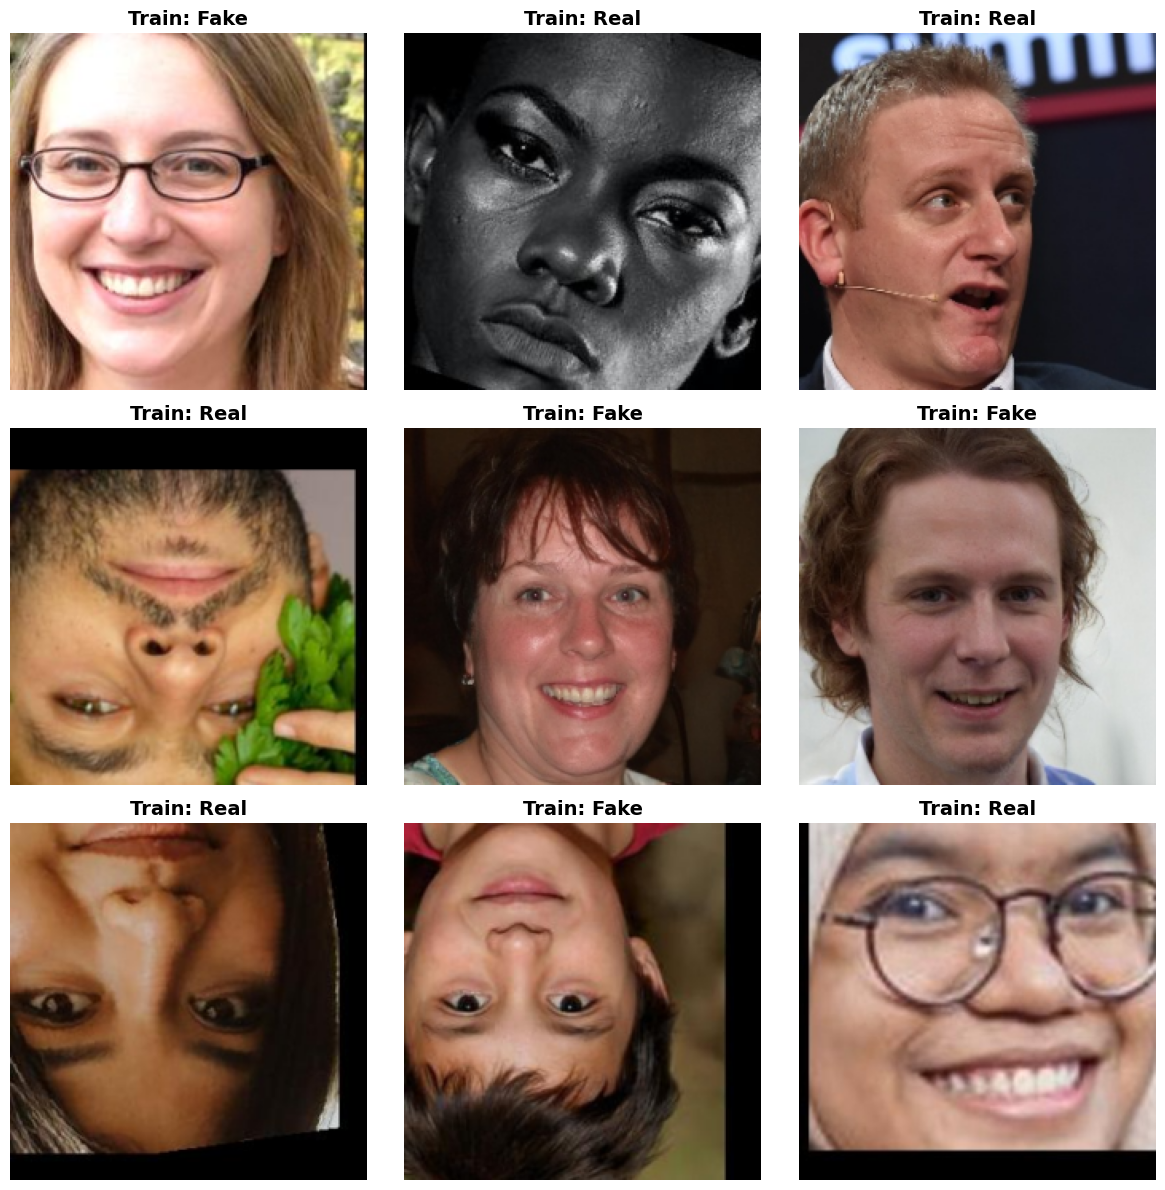

Validation samples saved to images/val_samples.png


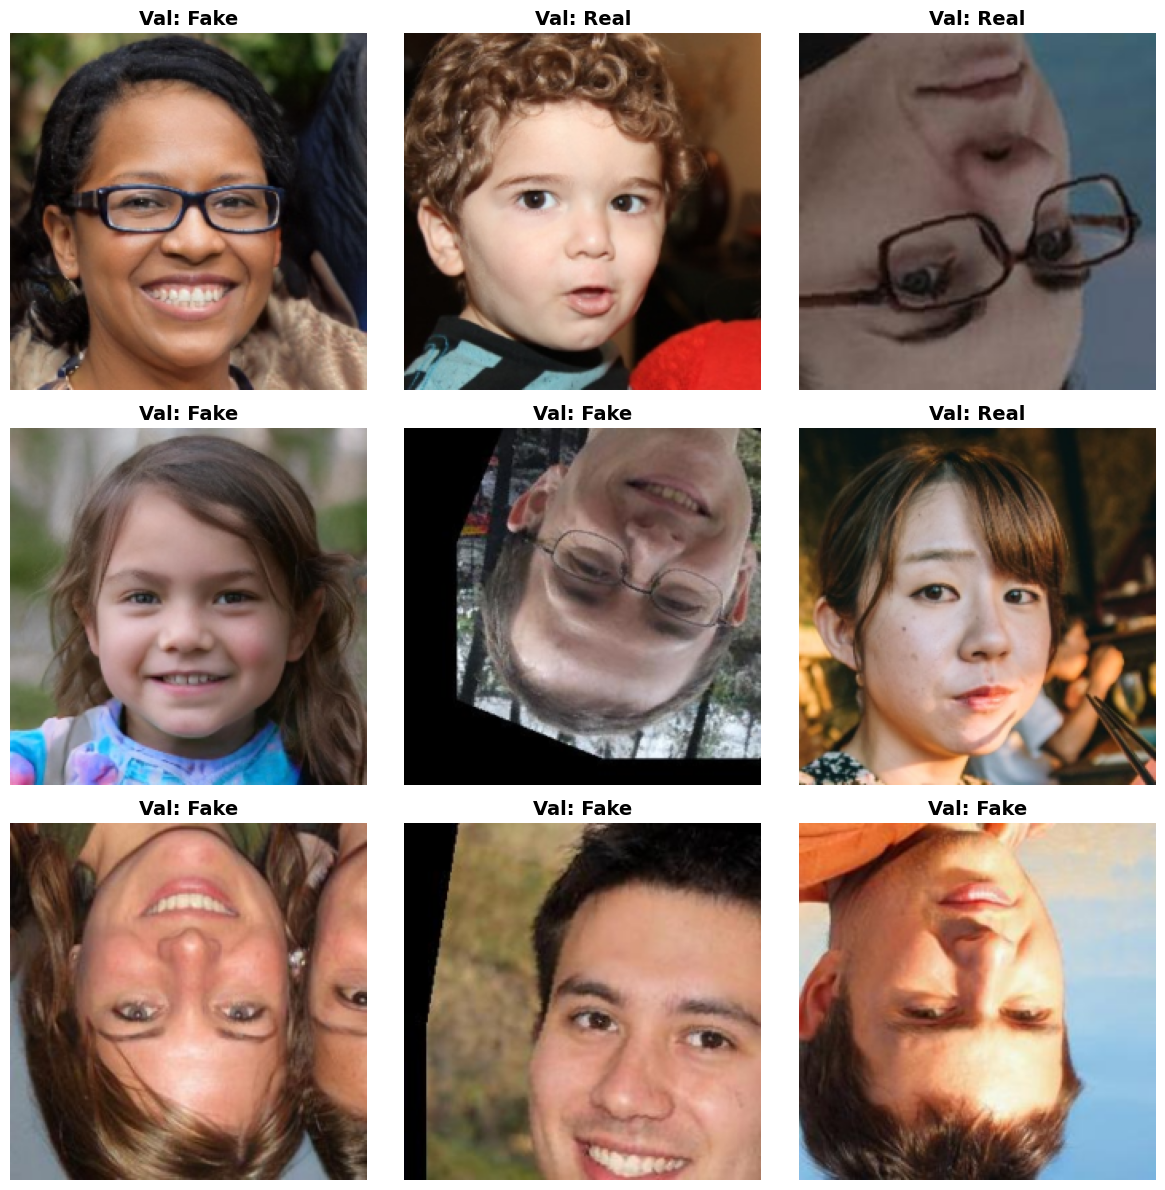

In [44]:
#plot a few real and fake images in a 3x3 grid (original, non-transformed images)
# Create a dataset without transformations for visualization
transform_viz = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset_viz = datasets.ImageFolder(root=DATA_DIR, transform=transform_viz)

# Split using the same seed for consistency
train_size = int(0.8 * len(dataset_viz))
val_size = len(dataset_viz) - train_size
train_dataset_viz, val_dataset_viz = torch.utils.data.random_split(
    dataset_viz, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Create loaders for visualization
train_loader_viz = DataLoader(train_dataset_viz, batch_size=32, shuffle=False)
val_loader_viz = DataLoader(val_dataset_viz, batch_size=32, shuffle=False)

# Get training images
dataiter = iter(train_loader_viz)
images, labels = next(dataiter)

# Create a 3x3 grid of training images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for idx in range(9):
    npimg = images[idx].numpy()
    axes[idx].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[idx].set_title(f'Train: {dataset.classes[labels[idx]]}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
if not os.path.exists('images'):
    os.makedirs('images')
plt.savefig('images/train_samples.png', dpi=150, bbox_inches='tight')
print('Training samples saved to images/train_samples.png')
plt.show()

# Get validation images
dataiter_val = iter(val_loader_viz)
images_val, labels_val = next(dataiter_val)

# Create a 3x3 grid of validation images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for idx in range(9):
    npimg = images_val[idx].numpy()
    axes[idx].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[idx].set_title(f'Val: {dataset.classes[labels_val[idx]]}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('images/val_samples.png', dpi=150, bbox_inches='tight')
print('Validation samples saved to images/val_samples.png')
plt.show()

In [45]:
# lets define a custom resnet model for this task 

from torchinfo import summary

class CustomResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet, self).__init__()
        
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x
    
# Instantiate the model, define loss function and optimizer
model = CustomResNet(num_classes=2).to(device)



summary(model, input_size=(batch_size, 3, 224, 224))

c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
CustomResNet                                  [256, 2]                  --
├─ResNet: 1-1                                 [256, 2]                  --
│    └─Conv2d: 2-1                            [256, 64, 112, 112]       9,408
│    └─BatchNorm2d: 2-2                       [256, 64, 112, 112]       128
│    └─ReLU: 2-3                              [256, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [256, 64, 56, 56]         --
│    └─Sequential: 2-5                        [256, 64, 56, 56]         --
│    │    └─BasicBlock: 3-1                   [256, 64, 56, 56]         73,984
│    │    └─BasicBlock: 3-2                   [256, 64, 56, 56]         73,984
│    └─Sequential: 2-6                        [256, 128, 28, 28]        --
│    │    └─BasicBlock: 3-3                   [256, 128, 28, 28]        230,144
│    │    └─BasicBlock: 3-4                   [256, 128, 28, 28]        295,42

In [49]:
hyperparameters = {
    'learning_rate': 0.0001,
    'num_epochs': 100,
    'weight_decay': 1e-4,
    
}


Starting training...

Epoch 1/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


Train Loss: 0.5947 Acc: 0.6835


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


Val Loss: 0.6304 Acc: 0.6486
Best model saved with val acc: 0.6486

Epoch 2/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Train Loss: 0.5677 Acc: 0.7145


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


Val Loss: 0.6327 Acc: 0.6559
Best model saved with val acc: 0.6559

Epoch 3/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Train Loss: 0.5375 Acc: 0.7324


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


Val Loss: 0.6148 Acc: 0.6699
Best model saved with val acc: 0.6699

Epoch 4/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Train Loss: 0.5155 Acc: 0.7479


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


Val Loss: 0.6798 Acc: 0.6668

Epoch 5/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Train Loss: 0.4921 Acc: 0.7603


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


Val Loss: 0.5864 Acc: 0.7060
Best model saved with val acc: 0.7060

Epoch 6/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Train Loss: 0.4615 Acc: 0.7898


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


Val Loss: 0.5903 Acc: 0.7083
Best model saved with val acc: 0.7083

Epoch 7/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


Train Loss: 0.4318 Acc: 0.7905


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


Val Loss: 0.5719 Acc: 0.7219
Best model saved with val acc: 0.7219

Epoch 8/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train Loss: 0.3885 Acc: 0.8254


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Val Loss: 0.5350 Acc: 0.7386
Best model saved with val acc: 0.7386

Epoch 9/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


Train Loss: 0.3750 Acc: 0.8289


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Val Loss: 0.5394 Acc: 0.7358

Epoch 10/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train Loss: 0.3628 Acc: 0.8344


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Val Loss: 0.5333 Acc: 0.7463
Best model saved with val acc: 0.7463

Epoch 11/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train Loss: 0.3569 Acc: 0.8355


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Val Loss: 0.5392 Acc: 0.7506
Best model saved with val acc: 0.7506

Epoch 12/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train Loss: 0.3498 Acc: 0.8448


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Val Loss: 0.5331 Acc: 0.7521
Best model saved with val acc: 0.7521

Epoch 13/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train Loss: 0.3463 Acc: 0.8460


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Val Loss: 0.5456 Acc: 0.7320

Epoch 14/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train Loss: 0.3382 Acc: 0.8510


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Val Loss: 0.5346 Acc: 0.7498

Epoch 15/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train Loss: 0.3325 Acc: 0.8510


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Val Loss: 0.5345 Acc: 0.7475

Epoch 16/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


Train Loss: 0.3297 Acc: 0.8553


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Val Loss: 0.5359 Acc: 0.7502

Epoch 17/100
--------------------------------------------------


Training: 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


Train Loss: 0.3281 Acc: 0.8526


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Val Loss: 0.5369 Acc: 0.7502

Early stopping triggered after 17 epochs

Training complete. Best val accuracy: 0.7521
Training history saved to images/training_history.png


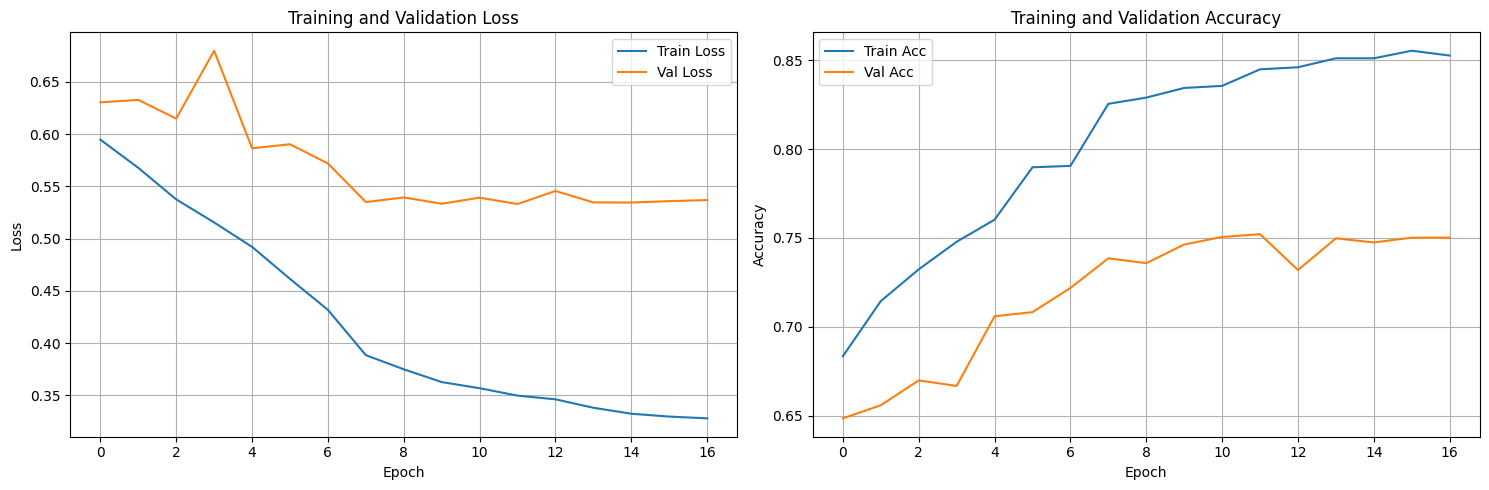

In [50]:
#TRAIN MODEL, USE VALIDATION SET FOR EARLY STOPPING, SAVE BEST MODEL BASED ON VAL ACCURACY

optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'],
                        weight_decay=hyperparameters['weight_decay'])

criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop with early stopping
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 5
patience_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print('Starting training...')
for epoch in range(hyperparameters['num_epochs']):
    print(f'\nEpoch {epoch+1}/{hyperparameters["num_epochs"]}')
    print('-' * 50)
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.cpu().item())
    
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.cpu().item())
    
    print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
    # Save best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Best model saved with val acc: {best_val_acc:.4f}')
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break
    
    scheduler.step()

print(f'\nTraining complete. Best val accuracy: {best_val_acc:.4f}')

# Load best model
model.load_state_dict(best_model_wts)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('images/training_history.png', dpi=150, bbox_inches='tight')
print('Training history saved to images/training_history.png')
plt.show()

100%|██████████| 31/31 [00:15<00:00,  1.97it/s]


Test Accuracy: 0.7347
Test Precision: 0.7305
Test Recall: 0.6670
Test F1-Score: 0.6973
Confusion Matrix:
[[3318  872]
 [1180 2364]]
Confusion matrix saved to images/confusion_matrix.png


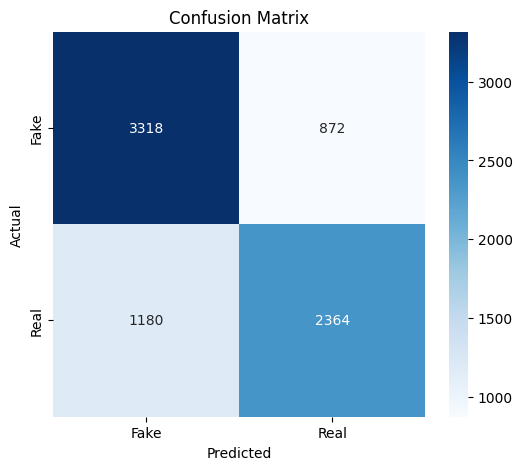

In [51]:
#load best model, and evaluate results on test set

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes,
                yticklabels=dataset.classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig('images/confusion_matrix.png', dpi=150, bbox_inches='tight')
    print('Confusion matrix saved to images/confusion_matrix.png')
    
    plt.show()
    
evaluate_model(model, test_loader)